## Importing the Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [31]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv') 
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [32]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)


In [33]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling


In [34]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [35]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

Here the minority class instances are of the indexes 6,1,4 (the last 3 instances)

In [36]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [37]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [38]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

klabel=kmeans.labels_
df_major['klabel']=klabel

df_major['klabel'].value_counts()

klabel
451    546
185    487
79     369
505    348
956    320
      ... 
397      2
775      2
542      2
665      2
12       1
Name: count, Length: 981, dtype: int64

The purpose of this code is to perform K-means clustering on a dataset (X) and then analyze the distribution of data points across the clusters. This information can be used for various purposes such as:

Understanding the natural groupings or patterns in the data.
Segmenting the data for further analysis or targeted actions.
Selecting representative samples from each cluster for downstream ta

## Eg
 Assuming df_major is a DataFrame containing the data and X is the feature matrix, the output of df_major['klabel'].value_counts() will be a Series where the index represents the cluster labels and the values represent the number of data points in each cluster.sks.

This output indicates that there are 1500 data points in cluster 0, 1200 data points in cluster 1, 900 data points in cluster 2, and so on.

In [39]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [40]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528470,-0.068426,-0.081806,-0.032573,-0.048343,-0.202326,-0.085798,-0.141625,-0.176448,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,133,0
1,-0.524593,0.704878,0.850340,0.027749,0.920410,0.603275,-0.211174,-0.082434,0.240596,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,406,0
2,-0.525233,0.300651,0.339163,0.020443,0.363712,0.603275,-0.211174,0.044064,0.439619,0.484295,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,682,0
3,-0.524560,0.652153,0.745098,0.026625,0.933533,0.603275,-0.211174,-0.074097,0.257378,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,406,0
4,-0.524555,0.757604,0.805237,0.028030,0.960037,0.603275,-0.211174,-0.091861,0.225734,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,406,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528463,-0.068426,-0.051737,-0.031309,-0.046220,-0.200831,0.457498,-0.064078,-0.255104,-0.517901,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,851,0
56657,-0.524840,-0.068426,-0.051737,-0.029904,-0.043932,-0.178412,0.770939,0.022086,-0.255104,-0.472838,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,976,0
56658,-0.215111,-0.015701,-0.021667,-0.013231,-0.016083,0.423920,-0.211174,0.269089,0.640328,0.711051,...,-0.108682,-0.081786,-0.127669,-0.093554,-0.256386,-0.137651,-0.269448,-0.238252,348,3
56659,-0.215111,0.037025,0.008402,-0.014823,0.058109,0.373103,-0.211174,0.050807,0.399311,1.528310,...,-0.108677,-0.081786,-0.127664,-0.093548,-0.256402,-0.137651,-0.269464,-0.238268,980,3


In [41]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

The purpose of this code is to sample a specified fraction of rows from each cluster in the DataFrame. This is useful for creating a smaller, more manageable dataset that still represents the distribution of the original data across different clusters.

In [42]:
result['Label'].value_counts()

Label
0    120
3    104
5     57
2     19
Name: count, dtype: int64

In [43]:
result = result.drop(['klabel'],axis=1)


In [44]:
result = pd.concat([result, df_minor], ignore_index=True)

In [45]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set using the sampled set

In [46]:
# Read the sampled dataset
df_sampled=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [47]:
X = df_sampled.drop(['Label'],axis=1).values
y = df_sampled.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature Engineering

### Feature selection by Information Gain

In [49]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

#### Interpretation
Higher Scores: Features with higher mutual information scores are more informative about the target variable.
Lower Scores: Features with lower scores provide less information about the targetity.

#### Use Case in Feature Selection
Mutual information scores can be used to select a subset of features that are most relevant to the target variable. This can improve model performance by reducing overfitting and computational complexity.

In [22]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [23]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [24]:
X_fs = df[fs].values
##  X_fs_1 is to be checked without using the FCBF Filter
X_fs_1=df[fs].values

In [25]:
X_fs.shape

(4482, 41)

### Feature selection by Fast Correlation Based Filter (FCBF)

This is a Moudule imported from GitHub repo: https://github.com/SantiagoEG/FCBF_module, which is a custom Module

Certain features are redundant because they contain very similar information. FCBF can remove redundant features by calculating the correlation between each pair of features.

In [26]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [27]:
X_fss = fcbf.fit_transform(X_fs,y)

In [28]:
X_fss.shape

(4482, 20)

## Re-split train & test sets after feature selection


This is done including the FCBF Filtering

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [30]:
X_train.shape

(3585, 20)

In [50]:
pd.Series(y_train).value_counts()

6    1744
1    1572
0      96
3      83
5      46
4      29
2      15
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [51]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [52]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [53]:
pd.Series(y_train).value_counts()

6    1744
1    1572
4    1000
2    1000
0      96
3      83
5      46
Name: count, dtype: int64

## Machine learning model training

### XGBoost with FCBF

Accuracy of XGBoost: 0.9899665551839465
Precision of XGBoost: 0.990711695185839
Recall of XGBoost: 0.9899665551839465
F1-score of XGBoost: 0.9898518041644682
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        24
           1       0.99      1.00      1.00       394
           2       0.80      1.00      0.89         4
           3       1.00      0.81      0.89        21
           4       1.00      1.00      1.00         7
           5       0.79      1.00      0.88        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.93      0.95      0.93       897
weighted avg       0.99      0.99      0.99       897



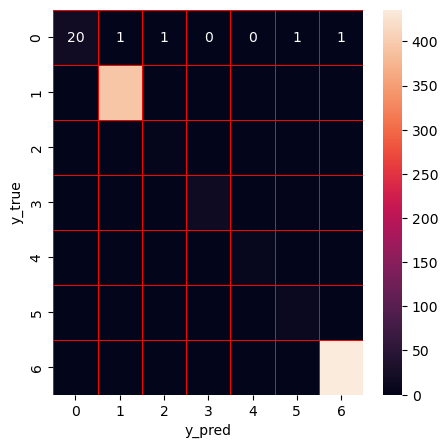

In [55]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [57]:
import hyperopt

In [58]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.56trial/s, best loss: -0.9933110367892977]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.8391029526621202, 'max_depth': 73.0, 'n_estimators': 25.0}


Accuracy of XGBoost: 0.9933110367892977
Precision of XGBoost: 0.9936947975810393
Recall of XGBoost: 0.9933110367892977
F1-score of XGBoost: 0.9931570687649496
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.99      1.00      1.00       394
           2       0.80      1.00      0.89         4
           3       1.00      0.90      0.95        21
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.95      0.96      0.95       897
weighted avg       0.99      0.99      0.99       897



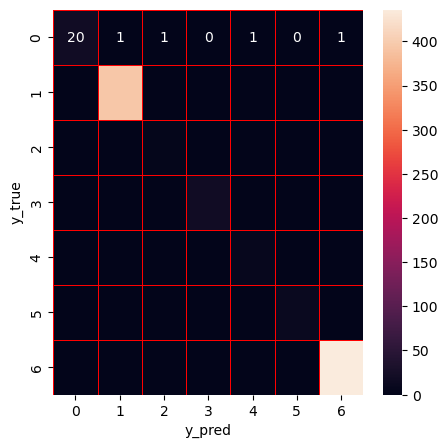

In [59]:
xg = xgb.XGBClassifier(learning_rate= 0.8391029526621202, n_estimators = 25, max_depth = 73)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [60]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### XGBoost without FCBF

In [86]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_fs_1,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
pd.Series(y_train_1).value_counts()
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})
X_train_1, y_train_1 = smote.fit_resample(X_train_1, y_train_1)

Accuracy of XGBoost: 0.9899665551839465
Precision of XGBoost: 0.9908488594509509
Recall of XGBoost: 0.9899665551839465
F1-score of XGBoost: 0.9897733449291053
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        24
           1       1.00      0.99      1.00       394
           2       0.60      0.75      0.67         4
           3       0.90      0.90      0.90        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       0.99      1.00      0.99       436

    accuracy                           0.99       897
   macro avg       0.90      0.91      0.90       897
weighted avg       0.99      0.99      0.99       897



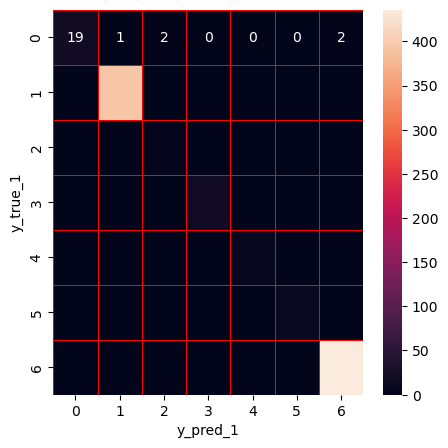

In [87]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train_1,y_train_1)
xg_score=xg.score(X_test_1,y_test_1)
y_predict_1=xg.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred_1")
plt.ylabel("y_true_1")
plt.show()

In [89]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train_1, y_train_1)
    y_pred_1 = clf.predict(X_test_1)
    score = accuracy_score(y_test_1, y_pred_1)

    return {'loss':-score, 'status': STATUS_OK }


space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97trial/s, best loss: -0.9899665551839465]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.1206862326628798, 'max_depth': 75.0, 'n_estimators': 55.0}


Accuracy of XGBoost: 0.9899665551839465
Precision of XGBoost: 0.9908488594509509
Recall of XGBoost: 0.9899665551839465
F1-score of XGBoost: 0.9897733449291053
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        24
           1       0.99      1.00      1.00       394
           2       0.67      1.00      0.80         4
           3       1.00      0.86      0.92        21
           4       1.00      1.00      1.00         7
           5       0.92      1.00      0.96        11
           6       0.99      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.94      0.95      0.94       897
weighted avg       0.99      0.99      0.99       897



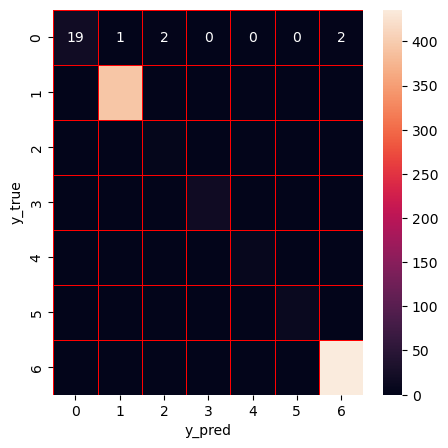

In [90]:
xg = xgb.XGBClassifier(learning_rate= 0.1206862326628798, n_estimators = 55, max_depth = 75)
xg.fit(X_train_1,y_train_1)
xg_score=xg.score(X_test_1,y_test_1)
y_predict=xg.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [119]:
xg_train_1=xg.predict(X_train_1)
xg_test_1=xg.predict(X_test_1)

### Random Forest

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})
X_train, y_train = smote.fit_resample(X_train, y_train)

Accuracy of RF: 0.9910813823857302
Precision of RF: 0.992838126072194
Recall of RF: 0.9910813823857302
F1-score of RF: 0.9912706704734332
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       1.00      1.00      1.00       394
           2       0.67      1.00      0.80         4
           3       1.00      0.86      0.92        21
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.91      0.96      0.92       897
weighted avg       0.99      0.99      0.99       897



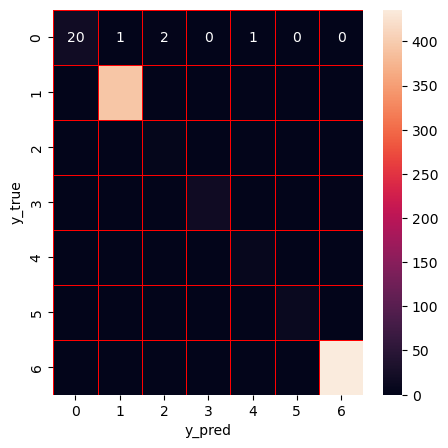

In [131]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [132]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/trial, best loss: -0.9888517279821628]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 45.0, 'max_features': 8.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 27.0}


Accuracy of RF: 0.9888517279821628
Precision of RF: 0.9903415425154555
Recall of RF: 0.9888517279821628
F1-score of RF: 0.9888901033214132
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        24
           1       1.00      1.00      1.00       394
           2       0.60      0.75      0.67         4
           3       1.00      0.86      0.92        21
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        11
           6       0.99      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.90      0.91      0.90       897
weighted avg       0.99      0.99      0.99       897



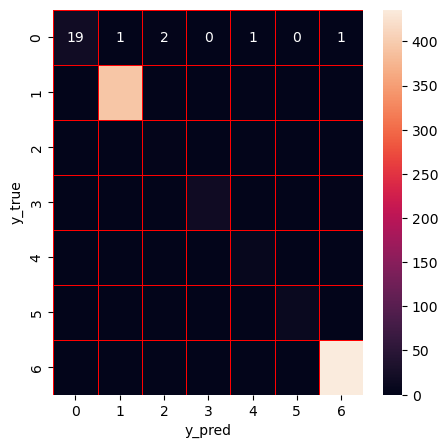

In [133]:
rf_hpo = RandomForestClassifier(n_estimators = 27, min_samples_leaf = 1, max_depth = 45, min_samples_split = 2, max_features = 8, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [135]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Random Forest without FCBF

In [120]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_fs_1,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
pd.Series(y_train_1).value_counts()
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})
X_train_1, y_train_1 = smote.fit_resample(X_train_1, y_train_1)

Accuracy of RF: 0.9855072463768116
Precision of RF: 0.9908488594509509
Recall of RF: 0.9899665551839465
F1-score of RF: 0.9897733449291053
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        24
           1       0.99      1.00      1.00       394
           2       0.67      1.00      0.80         4
           3       1.00      0.86      0.92        21
           4       1.00      1.00      1.00         7
           5       0.92      1.00      0.96        11
           6       0.99      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.94      0.95      0.94       897
weighted avg       0.99      0.99      0.99       897



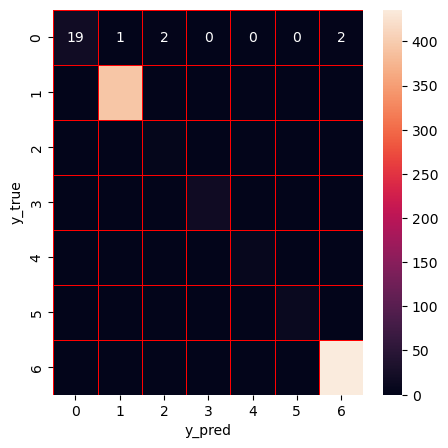

In [122]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train_1,y_train_1) 
rf_score=rf.score(X_test_1,y_test_1)
y_predict=rf.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [123]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train_1,y_train_1)
    score=clf.score(X_test_1,y_test_1)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.42s/trial, best loss: -0.9888517279821628]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 39.0, 'max_features': 15.0, 'min_samples_leaf': 1.0, 'min_samples_split': 8.0, 'n_estimators': 146.0}


Accuracy of RF: 0.9888517279821628
Precision of RF: 0.9897042873095219
Recall of RF: 0.9888517279821628
F1-score of RF: 0.9887491783612881
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        24
           1       0.99      1.00      1.00       394
           2       0.60      0.75      0.67         4
           3       0.95      0.86      0.90        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       0.99      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.90      0.91      0.90       897
weighted avg       0.99      0.99      0.99       897



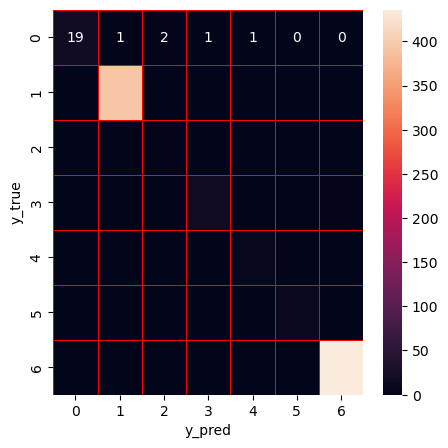

In [136]:
rf_hpo = RandomForestClassifier(n_estimators = 146, min_samples_leaf = 1, max_depth = 39, min_samples_split = 8, max_features = 15, criterion = 'entropy')
rf_hpo.fit(X_train_1,y_train_1)
rf_score=rf_hpo.score(X_test_1,y_test_1)
y_predict_1=rf_hpo.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [137]:
rf_train_1=rf_hpo.predict(X_train_1)
rf_test_1=rf_hpo.predict(X_test_1)

### Decision Tree

Accuracy of DT: 0.9855072463768116
Precision of DT: 0.9853796766840245
Recall of DT: 0.9855072463768116
F1-score of DT: 0.9851079428403384
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        24
           1       1.00      1.00      1.00       394
           2       0.50      0.50      0.50         4
           3       0.94      0.81      0.87        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       0.99      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.87      0.87      0.86       897
weighted avg       0.99      0.99      0.99       897



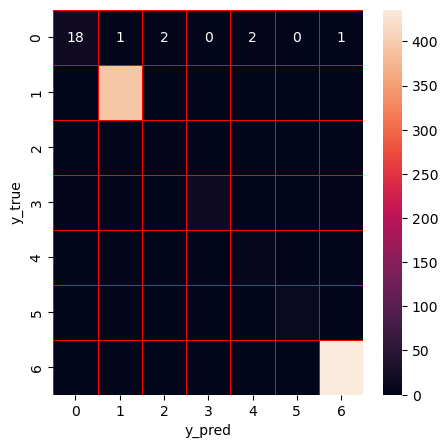

In [79]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [80]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.71trial/s, best loss: -0.9888517279821628]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 17.0, 'max_features': 20.0, 'min_samples_leaf': 4.0, 'min_samples_split': 8.0}


Accuracy of DT: 0.9866220735785953
Precision of DT: 0.9876238453261827
Recall of DT: 0.9866220735785953
F1-score of DT: 0.9862948192360103
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        24
           1       1.00      0.99      1.00       394
           2       0.60      0.75      0.67         4
           3       0.90      0.90      0.90        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       0.99      1.00      0.99       436

    accuracy                           0.99       897
   macro avg       0.90      0.91      0.90       897
weighted avg       0.99      0.99      0.99       897



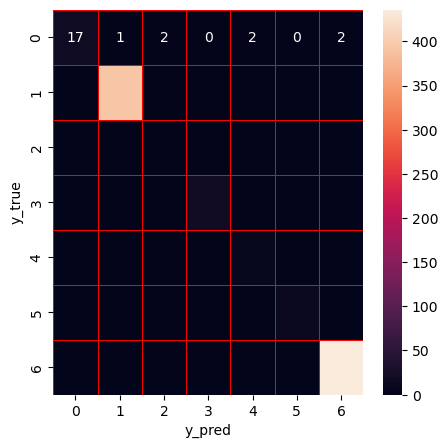

In [81]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 4, max_depth = 17, min_samples_split = 8, max_features = 20, criterion = 'entropy')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [138]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### DF without FCBF

Accuracy of DT: 0.9855072463768116
Precision of DT: 0.9854025201851289
Recall of DT: 0.9855072463768116
F1-score of DT: 0.9852464883947631
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        24
           1       1.00      1.00      1.00       394
           2       0.60      0.75      0.67         4
           3       0.94      0.81      0.87        21
           4       1.00      1.00      1.00         7
           5       0.91      0.91      0.91        11
           6       0.99      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.89      0.89      0.89       897
weighted avg       0.99      0.99      0.99       897



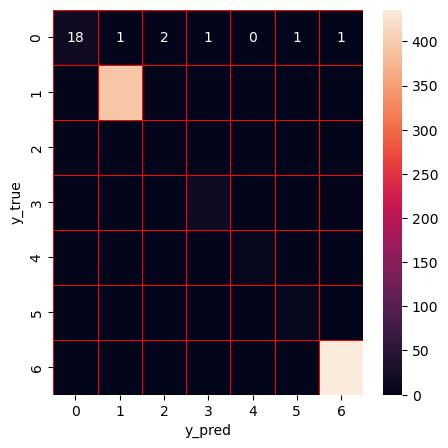

In [139]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train_1,y_train_1) 
dt_score=dt.score(X_test_1,y_test_1)
y_predict_1=dt.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [140]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train_1,y_train_1)
    score=clf.score(X_test_1,y_test_1)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.61trial/s, best loss: -0.9888517279821628]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 34.0, 'max_features': 12.0, 'min_samples_leaf': 2.0, 'min_samples_split': 9.0}


Accuracy of DT: 0.9866220735785953
Precision of DT: 0.9869920036623274
Recall of DT: 0.9866220735785953
F1-score of DT: 0.9863689938815519
              precision    recall  f1-score   support

           0       0.89      0.71      0.79        24
           1       1.00      1.00      1.00       394
           2       0.60      0.75      0.67         4
           3       0.90      0.90      0.90        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        11
           6       0.99      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.88      0.91      0.89       897
weighted avg       0.99      0.99      0.99       897



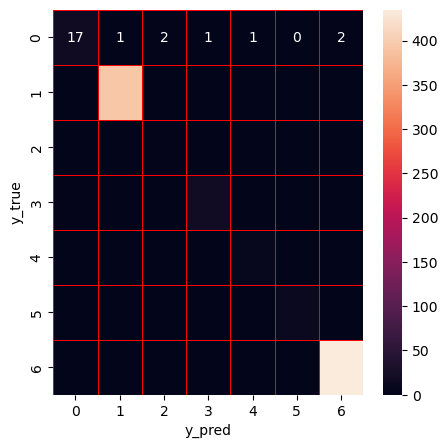

In [141]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 34, min_samples_split = 9, max_features = 12, criterion = 'entropy')
dt_hpo.fit(X_train_1,y_train_1)
dt_score=dt_hpo.score(X_test_1,y_test_1)
y_predict_1=dt_hpo.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [143]:
dt_train_1=dt_hpo.predict(X_train_1)
dt_test_1=dt_hpo.predict(X_test_1)

### CNN

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2687 - loss: -425.5373 - val_accuracy: 0.4392 - val_loss: -3571.8103
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2859 - loss: -14795.8389 - val_accuracy: 0.4392 - val_loss: -33002.1445
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2741 - loss: -96333.0469 - val_accuracy: 0.4392 - val_loss: -116287.6641
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2763 - loss: -299159.6250 - val_accuracy: 0.4392 - val_loss: -276481.5938
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2898 - loss: -618458.5000 - val_accuracy: 0.4392 - val_loss: -535111.2500
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2842 - loss: -1206724.0000 - val_accuracy: 0.4392 - val_loss: -903703.3125
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2797 - loss: -1927833.2500 - val_accuracy: 0.4392 - val_loss: -1389828.8750
Epoch 8/10
174/174 ━━━━━━

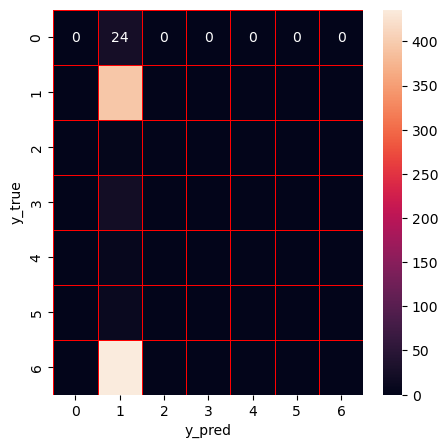

In [109]:
# Reshape the data for CNN input (assuming your data is not in image format)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create and compile CNN model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
model_cnn.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))

# Evaluate CNN model
cnn_score = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print('Accuracy of CNN: ' + str(cnn_score[1]))

# Predict using the model
y_predict_cnn = (model_cnn.predict(X_test_cnn) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test, y_predict_cnn, average='weighted')
print('Precision of CNN: ' + str(precision_cnn))
print('Recall of CNN: ' + str(recall_cnn))
print('F1-score of CNN: ' + str(fscore_cnn))

# Print classification report
print(classification_report(y_test, y_predict_cnn))

# Confusion matrix
cm_cnn = confusion_matrix(y_test, y_predict_cnn)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|████████████████████████████████████████████████████████████| 50/50 [10:55<00:00, 13.11s/trial, best loss: -0.4392419159412384]
CNN: Hyperopt estimated optimum {'dense_units': 37.0, 'epochs': 14.0, 'filters': 78.0, 'kernel_size': 5.0, 'pool_size': 4.0}
Epoch 1/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2872 - loss: -172.4389 - val_accuracy: 0.4392 - val_loss: -1206.9541
Epoch 2/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2899 - loss: -5448.0864 - val_accuracy: 0.4392 - val_loss: -9798.4863
Epoch 3/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2876 - loss: -27791.1367 - val_accuracy: 0.4392 - val_loss: -33946.9727
Epoch 4/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2828 - loss: -91807.7188 - val_accuracy: 0.4392 - val_loss: -78952.3281
Epoch 5/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2882 - loss: -195989.7656 - val_accuracy: 0.4392 - val_loss: -149537.3438
Epoch 6/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - a

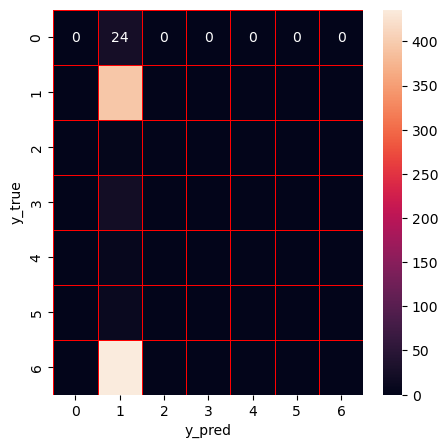

In [144]:
# Define the objective function for CNN
def cnn_objective(params):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=int(params['filters']), kernel_size=int(params['kernel_size']), activation='relu', input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.MaxPooling1D(pool_size=int(params['pool_size'])),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(int(params['dense_units']), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train, epochs=int(params['epochs']), validation_data=(X_test_cnn, y_test), verbose=0)
    _, accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter configuration space for CNN
cnn_space = {
    'filters': hp.quniform('filters', 32, 128, 1),
    'kernel_size': hp.quniform('kernel_size', 3, 10, 1),
    'pool_size': hp.quniform('pool_size', 2, 5, 1),
    'dense_units': hp.quniform('dense_units', 32, 128, 1),
    'epochs': hp.quniform('epochs', 5, 20, 1)
}

# Perform hyperparameter optimization for CNN
cnn_trials = Trials()
best_cnn = fmin(fn=cnn_objective, space=cnn_space, algo=tpe.suggest, max_evals=50, trials=cnn_trials)

print("CNN: Hyperopt estimated optimum {}".format(best_cnn))

# Extract the best hyperparameters for CNN
best_filters = int(best_cnn['filters'])
best_kernel_size = int(best_cnn['kernel_size'])
best_pool_size = int(best_cnn['pool_size'])
best_dense_units = int(best_cnn['dense_units'])
best_epochs = int(best_cnn['epochs'])

# Create and train CNN model with best hyperparameters
cnn_hpo = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=best_filters, kernel_size=best_kernel_size, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=best_pool_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(best_dense_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_hpo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_hpo.fit(X_train_cnn, y_train, epochs=best_epochs, validation_data=(X_test_cnn, y_test))

# Evaluate CNN model with best hyperparameters
cnn_score = cnn_hpo.evaluate(X_test_cnn, y_test, verbose=0)
print('Accuracy of CNN with best hyperparameters: ' + str(cnn_score[1]))

# Predict using the CNN model with best hyperparameters
y_predict_cnn = (cnn_hpo.predict(X_test_cnn) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score for CNN model
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test, y_predict_cnn, average='weighted')
print('Precision of CNN with best hyperparameters: ' + str(precision_cnn))
print('Recall of CNN with best hyperparameters: ' + str(recall_cnn))
print('F1-score of CNN with best hyperparameters: ' + str(fscore_cnn))

# Print classification report for CNN model
print(classification_report(y_test, y_predict_cnn))

# Confusion matrix for CNN model
cm_cnn = confusion_matrix(y_test, y_predict_cnn)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [150]:
cnn_train=cnn_hpo.predict(X_train_cnn)
cnn_test=cnn_hpo.predict(X_test_cnn)

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### CNN without FCBF

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2828 - loss: -1015.1508 - val_accuracy: 0.4392 - val_loss: -9339.7002
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2751 - loss: -33128.1094 - val_accuracy: 0.4392 - val_loss: -85489.6406
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2867 - loss: -199456.6406 - val_accuracy: 0.4392 - val_loss: -302303.7500
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2880 - loss: -590830.5625 - val_accuracy: 0.4392 - val_loss: -719191.6875
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2883 - loss: -1404386.5000 - val_accuracy: 0.4392 - val_loss: -1382720.8750
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2947 - loss: -2531762.0000 - val_accuracy: 0.4392 - val_loss: -2333994.0000
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2869 - loss: -4005921.2500 - val_accuracy: 0.4392 - val_loss: -3613872.0000
Epoch 8/10
174/174 ━

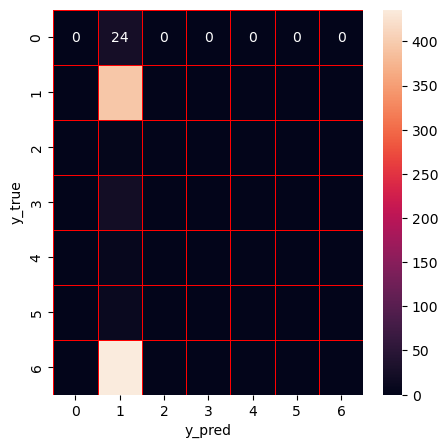

In [149]:
# Reshape the data for CNN input (assuming your data is not in image format)
X_train_cnn_1 = X_train_1.reshape(X_train_1.shape[0], X_train_1.shape[1], 1)
X_test_cnn_1 = X_test_1.reshape(X_test_1.shape[0], X_test_1.shape[1], 1)

# Create and compile CNN model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn_1.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
model_cnn.fit(X_train_cnn_1, y_train_1, epochs=10, validation_data=(X_test_cnn_1, y_test_1))

# Evaluate CNN model
cnn_score = model_cnn.evaluate(X_test_cnn_1, y_test_1, verbose=0)
print('Accuracy of CNN: ' + str(cnn_score[1]))

# Predict using the model
y_predict_cnn_1 = (model_cnn.predict(X_test_cnn_1) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test_1, y_predict_cnn_1, average='weighted')
print('Precision of CNN: ' + str(precision_cnn))
print('Recall of CNN: ' + str(recall_cnn))
print('F1-score of CNN: ' + str(fscore_cnn))

# Print classification report
print(classification_report(y_test_1, y_predict_cnn_1))

# Confusion matrix
cm_cnn = confusion_matrix(y_test_1, y_predict_cnn_1)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|████████████████████████████████████████████████████████████| 50/50 [06:42<00:00,  8.05s/trial, best loss: -0.4392419159412384]
CNN: Hyperopt estimated optimum {'dense_units': 34.0, 'epochs': 15.0, 'filters': 91.0, 'kernel_size': 8.0, 'pool_size': 4.0}
Epoch 1/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2790 - loss: -242.6549 - val_accuracy: 0.4392 - val_loss: -1830.2183
Epoch 2/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2841 - loss: -8370.1582 - val_accuracy: 0.4392 - val_loss: -16220.9180
Epoch 3/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2945 - loss: -45116.0273 - val_accuracy: 0.4392 - val_loss: -57301.4258
Epoch 4/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2865 - loss: -150692.0156 - val_accuracy: 0.4392 - val_loss: -133145.6719
Epoch 5/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2786 - loss: -324891.5938 - val_accuracy: 0.4392 - val_loss: -252155.3594
Epoch 6/15
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

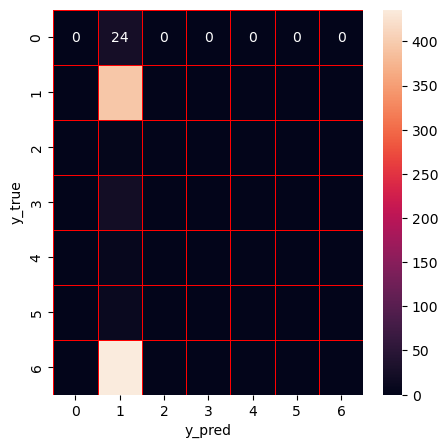

In [152]:
# Define the objective function for CNN
def cnn_objective(params):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=int(params['filters']), kernel_size=int(params['kernel_size']), activation='relu', input_shape=(X_train_1.shape[1], 1)),
        tf.keras.layers.MaxPooling1D(pool_size=int(params['pool_size'])),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(int(params['dense_units']), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn_1, y_train_1, epochs=int(params['epochs']), validation_data=(X_test_cnn_1, y_test_1), verbose=0)
    _, accuracy = model.evaluate(X_test_cnn_1, y_test_1, verbose=0)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter configuration space for CNN
cnn_space = {
    'filters': hp.quniform('filters', 32, 128, 1),
    'kernel_size': hp.quniform('kernel_size', 3, 10, 1),
    'pool_size': hp.quniform('pool_size', 2, 5, 1),
    'dense_units': hp.quniform('dense_units', 32, 128, 1),
    'epochs': hp.quniform('epochs', 5, 20, 1)
}

# Perform hyperparameter optimization for CNN
cnn_trials = Trials()
best_cnn = fmin(fn=cnn_objective, space=cnn_space, algo=tpe.suggest, max_evals=50, trials=cnn_trials)

print("CNN: Hyperopt estimated optimum {}".format(best_cnn))

# Extract the best hyperparameters for CNN
best_filters = int(best_cnn['filters'])
best_kernel_size = int(best_cnn['kernel_size'])
best_pool_size = int(best_cnn['pool_size'])
best_dense_units = int(best_cnn['dense_units'])
best_epochs = int(best_cnn['epochs'])

# Create and train CNN model with best hyperparameters
cnn_hpo = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=best_filters, kernel_size=best_kernel_size, activation='relu', input_shape=(X_train_cnn_1.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=best_pool_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(best_dense_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_hpo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_hpo.fit(X_train_cnn_1, y_train_1, epochs=best_epochs, validation_data=(X_test_cnn_1, y_test_1))

# Evaluate CNN model with best hyperparameters
cnn_score = cnn_hpo.evaluate(X_test_cnn_1, y_test_1, verbose=0)
print('Accuracy of CNN with best hyperparameters: ' + str(cnn_score[1]))

# Predict using the CNN model with best hyperparameters
y_predict_cnn_1 = (cnn_hpo.predict(X_test_cnn_1) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score for CNN model
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test_1, y_predict_cnn_1, average='weighted')
print('Precision of CNN with best hyperparameters: ' + str(precision_cnn))
print('Recall of CNN with best hyperparameters: ' + str(recall_cnn))
print('F1-score of CNN with best hyperparameters: ' + str(fscore_cnn))

# Print classification report for CNN model
print(classification_report(y_test_1, y_predict_cnn_1))

# Confusion matrix for CNN model
cm_cnn = confusion_matrix(y_test_1, y_predict_cnn_1)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [155]:
cnn_train_1=cnn_hpo.predict(X_train_cnn_1)
cnn_test_1=cnn_hpo.predict(X_test_cnn_1)

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### LSTM

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2717 - loss: -15.2799 - val_accuracy: 0.4392 - val_loss: -53.3661
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2887 - loss: -56.1736 - val_accuracy: 0.4392 - val_loss: -83.2257
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3006 - loss: -81.0215 - val_accuracy: 0.4392 - val_loss: -111.8665
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2820 - loss: -109.0729 - val_accuracy: 0.4392 - val_loss: -140.0539
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2798 - loss: -137.6945 - val_accuracy: 0.4392 - val_loss: -167.9424
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2895 - loss: -161.9258 - val_accuracy: 0.4392 - val_loss: -197.4823
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2769 - loss: -190.1277 - val_accuracy: 0.4392 - val_loss: -227.0484
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accur

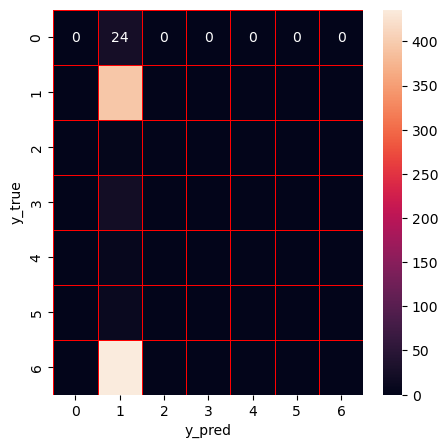

In [100]:

model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate LSTM model
lstm_score = model_lstm.evaluate(X_test, y_test, verbose=0)
print('Accuracy of LSTM: ' + str(lstm_score[1]))

# Predict using the model
y_predict_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score
precision_lstm, recall_lstm, fscore_lstm, _ = precision_recall_fscore_support(y_test, y_predict_lstm, average='weighted')
print('Precision of LSTM: ' + str(precision_lstm))
print('Recall of LSTM: ' + str(recall_lstm))
print('F1-score of LSTM: ' + str(fscore_lstm))

# Print classification report
print(classification_report(y_test, y_predict_lstm))

# Confusion matrix
cm_lstm = confusion_matrix(y_test, y_predict_lstm)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_lstm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


100%|████████████████████████████████████████████████████████████| 50/50 [28:34<00:00, 34.28s/trial, best loss: -0.4392419159412384]
LSTM: Hyperopt estimated optimum {'epochs': 14.0, 'units': 46.0}
Epoch 1/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2850 - loss: -11.0042 - val_accuracy: 0.4392 - val_loss: -40.6659
Epoch 2/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2846 - loss: -43.3259 - val_accuracy: 0.4392 - val_loss: -63.5845
Epoch 3/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2893 - loss: -63.4439 - val_accuracy: 0.4392 - val_loss: -85.1895
Epoch 4/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2728 - loss: -85.0392 - val_accuracy: 0.4392 - val_loss: -106.3415
Epoch 5/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2777 - loss: -104.4624 - val_accuracy: 0.4392 - val_loss: -127.2883
Epoch 6/14
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2938 - loss: -121.7973 - val_accuracy: 0.4392 - val_loss: -148.0342

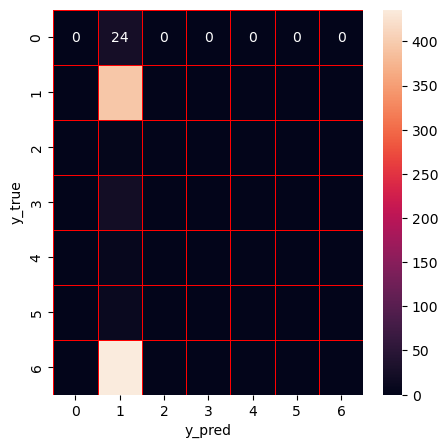

In [117]:
# Define the objective function for LSTM
def lstm_objective(params):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=int(params['units']), input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=int(params['epochs']), validation_data=(X_test, y_test), verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter configuration space for LSTM
lstm_space = {
    'units': hp.quniform('units', 32, 128, 1),
    'epochs': hp.quniform('epochs', 5, 20, 1)
}

# Perform hyperparameter optimization for LSTM
lstm_trials = Trials()
best_lstm = fmin(fn=lstm_objective, space=lstm_space, algo=tpe.suggest, max_evals=50, trials=lstm_trials)

print("LSTM: Hyperopt estimated optimum {}".format(best_lstm))

# Extract the best hyperparameters for LSTM
best_units = int(best_lstm['units'])
best_epochs = int(best_lstm['epochs'])

# Create and train LSTM model with best hyperparameters
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=best_units, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=best_epochs, validation_data=(X_test, y_test))

# Evaluate LSTM model with best hyperparameters
lstm_score = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Accuracy of LSTM with best hyperparameters: ' + str(lstm_score[1]))

# Predict using the LSTM model with best hyperparameters
y_predict_lstm = (lstm_model.predict(X_test) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score for LSTM model
precision_lstm, recall_lstm, fscore_lstm, _ = precision_recall_fscore_support(y_test, y_predict_lstm, average='weighted')
print('Precision of LSTM with best hyperparameters: ' + str(precision_lstm))
print('Recall of LSTM with best hyperparameters: ' + str(recall_lstm))
print('F1-score of LSTM with best hyperparameters: ' + str(fscore_lstm))

# Print classification report for LSTM model
print(classification_report(y_test, y_predict_lstm))

# Confusion matrix for LSTM model
cm_lstm = confusion_matrix(y_test, y_predict_lstm)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_lstm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [153]:
lstm_train=lstm_model.predict(X_train)
lstm_test=lstm_model.predict(X_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, CNN, LSTM, XGBoost)

In [154]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'CNN': cnn_train.ravel(),
    'LSTM': lstm_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,CNN,LSTM,XgBoost
0,1,1,1.0,1.0,1
1,1,1,1.0,1.0,1
2,1,1,1.0,1.0,1
3,1,1,1.0,1.0,1
4,6,6,1.0,1.0,6


In [156]:
dt_train=dt_train.reshape(-1, 1)
cnn_train=cnn_train.reshape(-1, 1)
lstm_train=lstm_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)

dt_test=dt_test.reshape(-1, 1)
cnn_test=cnn_test.reshape(-1, 1)
lstm_test=lstm_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [157]:
dt_train.shape

(5541, 1)

In [158]:
x_train = np.concatenate(( dt_train, cnn_train, lstm_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, cnn_test, lstm_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9899665551839465
Precision of Stacking: 0.9922992929246652
Recall of Stacking: 0.9899665551839465
F1-score of Stacking: 0.9903712154617154
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       1.00      1.00      1.00       394
           2       0.75      0.75      0.75         4
           3       1.00      0.86      0.92        21
           4       0.58      1.00      0.74         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.90      0.92      0.90       897
weighted avg       0.99      0.99      0.99       897



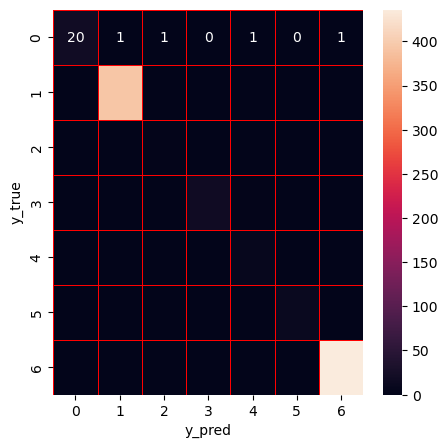

In [159]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [160]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|█████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.01trial/s, best loss: -0.992196209587514]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.22000784172473817, 'max_depth': 49.0, 'n_estimators': 35.0}


Accuracy of XGBoost: 0.992196209587514
Precision of XGBoost: 0.9924470919855077
Recall of XGBoost: 0.992196209587514
F1-score of XGBoost: 0.9920721150523576
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       1.00      1.00      1.00       394
           2       0.75      0.75      0.75         4
           3       0.91      0.95      0.93        21
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00       436

    accuracy                           0.99       897
   macro avg       0.93      0.93      0.93       897
weighted avg       0.99      0.99      0.99       897



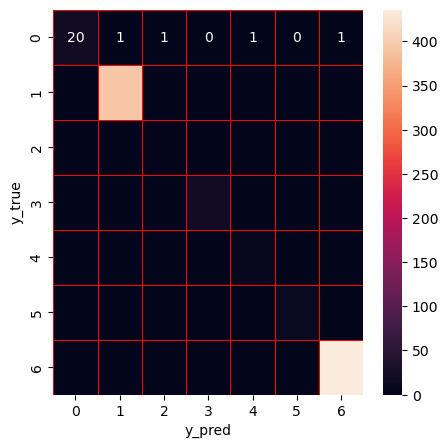

In [161]:
xg = xgb.XGBClassifier(learning_rate= 0.22000784172473817, n_estimators = 35, max_depth = 49)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()